## Modeling for predicting 72h ED revisit at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))


In [2]:
pd.set_option('display.max_columns', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,1,0,0,0,1,0,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.047332185886402756 : 1


### 3.  Modeling script

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.8610775470733643 seconds
AUC: 0.6782031005273577
Sensiticity: 0.5864559819413092
Specificity: 0.6628665951359085
Score thresold: 0.04089600611861725


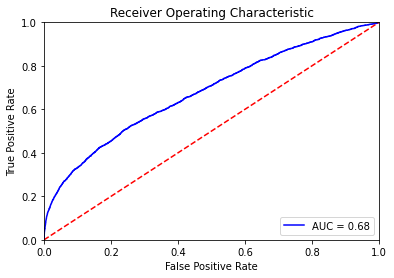

AP: 0.1665483811909529


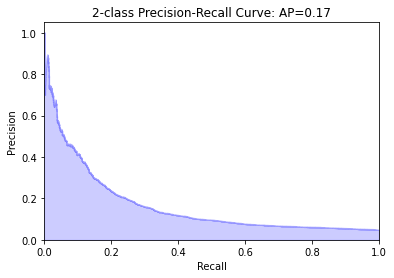

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
end = time.time()
print('Training time:', end - start, 'seconds')
PlotROCCurve(logreg.predict_proba(X_test)[:,1],y_test)


MLP:
Training time: 103.9253568649292 seconds
AUC: 0.6892288080036945
Sensiticity: 0.6099322799097066
Specificity: 0.6578370886981402
Score thresold: 0.02999314996678443


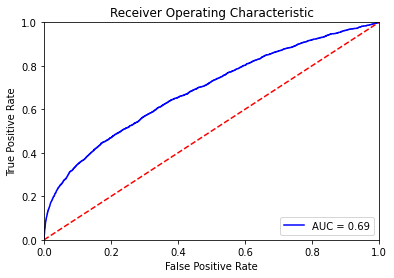

AP: 0.16989962088770205


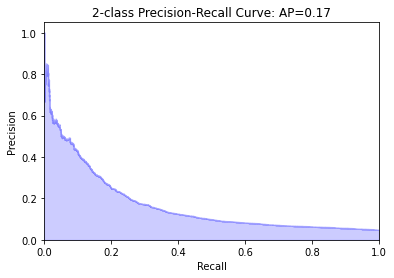

In [13]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
end = time.time()
print('Training time:', end - start, 'seconds')
PlotROCCurve(mlp.predict_proba(X_test)[:,1],y_test)

RandomForest:
Training time: 31.27682876586914 seconds
AUC: 0.665397111763984
Sensiticity: 0.6103837471783295
Specificity: 0.6245082260371959
Score thresold: 0.05


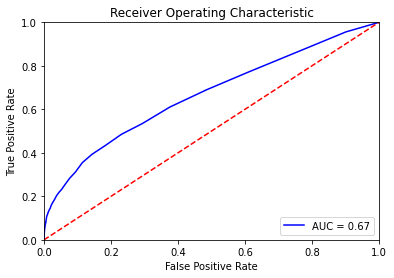

AP: 0.15553977072393538
[0.08412853 0.01445236 0.01918849 0.02385856 0.03398349 0.00967351
 0.0128399  0.02102607 0.00108622 0.00211751 0.00414253 0.04403748
 0.02335931 0.00512201 0.0086882  0.00579238 0.00024474 0.00563165
 0.00233398 0.00407674 0.00323301 0.00193223 0.00311361 0.00277293
 0.00285433 0.00267314 0.00280458 0.00138958 0.00594967 0.00194963
 0.00164417 0.00407747 0.00545992 0.00283303 0.0013133  0.00297392
 0.00316051 0.00149245 0.00165487 0.00161081 0.00520696 0.00235876
 0.00247444 0.00285112 0.00665279 0.0046844  0.00375638 0.00099164
 0.00360764 0.00466849 0.00293934 0.0053728  0.00145225 0.00371912
 0.00525003 0.00508468 0.00343257 0.00636063 0.06676559 0.07620024
 0.03750465 0.0407526  0.07886162 0.07575118 0.08390718 0.03892186
 0.04979425]


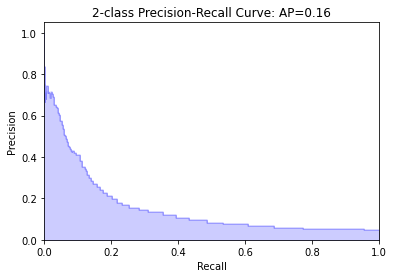

In [14]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
end = time.time()
print('Training time:', end - start, 'seconds')
PlotROCCurve(rf.predict_proba(X_test)[:,1],y_test)
importances = rf.feature_importances_
print(importances)

GradientBoosting:
Training time: 32.31457185745239 seconds
AUC: 0.6956210167620949
Sensiticity: 0.5873589164785553
Specificity: 0.6903388769670958
Score thresold: 0.04020764428743692


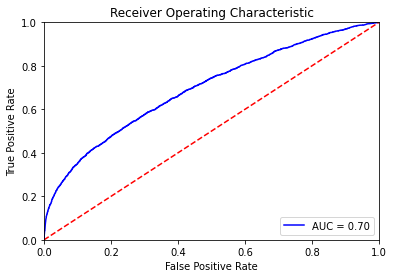

AP: 0.173225280930902


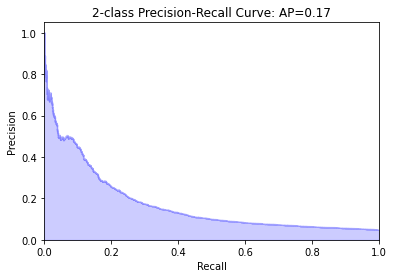

In [15]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
end = time.time()
print('Training time:', end - start, 'seconds')
PlotROCCurve(gb.predict_proba(X_test)[:,1],y_test)
# importances2 = gb.feature_importances_
# prediction_one=gb.predict_proba(X_cnnlstm_test_regression)

Support Vector Machine:
Training time: 4132.452099323273 seconds
AUC: 0.6240160887691866
Sensiticity: 0.3760722347629797
Specificity: 0.8719599427753935
Score thresold: 1


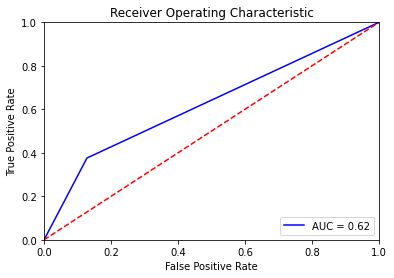

AP: 0.0771819587489431


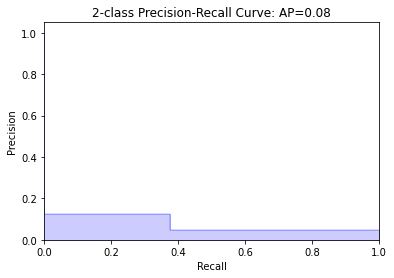

In [12]:
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC(class_weight = 'balanced')
start = time.time()
svc.fit(X_train,y_train)
end = time.time()
print('Training time:', end - start, 'seconds')
PlotROCCurve(svc.predict(X_test),y_test)


### 4. Performance output